In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/av-loandefaulter/test.csv
/kaggle/input/av-loandefaulter/train.csv


**Importing necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
                            recall_score, f1_score, roc_auc_score, classification_report,\
                            roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE

Using TensorFlow backend.


In [4]:
# load dataframe
train_df = pd.read_csv("/kaggle/input/av-loandefaulter/train.csv")
test_df = pd.read_csv("/kaggle/input/av-loandefaulter/test.csv")
ref_test_df = copy.copy(test_df)

# Seperate the features and target
y = train_df.loc[:,'m13']
train_df.drop("m13",axis=1, inplace=True)
train_df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,0,1,0,0,0,0,0
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,0,1,0
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,0,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,2,3,4,5,6,7,8,9,10,11


In [5]:
# 1. drop unwanted columns from all dataframes
def drop_col(dataset, col_to_drop):
    dataset.drop(col_to_drop, axis=1, inplace=True)
    return dataset

col_to_drop = ['loan_id']
train_df = drop_col(train_df,col_to_drop)
test_df = drop_col(test_df,col_to_drop)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116058 entries, 0 to 116057
Data columns (total 27 columns):
source                      116058 non-null object
financial_institution       116058 non-null object
interest_rate               116058 non-null float64
unpaid_principal_bal        116058 non-null int64
loan_term                   116058 non-null int64
origination_date            116058 non-null object
first_payment_date          116058 non-null object
loan_to_value               116058 non-null int64
number_of_borrowers         116058 non-null float64
debt_to_income_ratio        116058 non-null float64
borrower_credit_score       116058 non-null float64
loan_purpose                116058 non-null object
insurance_percent           116058 non-null float64
co-borrower_credit_score    116058 non-null float64
insurance_type              116058 non-null float64
m1                          116058 non-null int64
m2                          116058 non-null int64
m3                  

In [7]:
train_df.iloc[:,8:].describe(include = 'all')

,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
count,116058.000000,116058.000000,116058.000000,116058,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,A23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,58462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.593186,30.742293,769.926778,NaN,2.786288,459.611565,0.003257,0.003197,0.002059,0.001973,0.002180,0.003533,0.003421,0.004162,0.004825,0.005359,0.006617,0.007109,0.008065
std,0.491242,9.730798,42.210706,NaN,8.096464,381.946926,0.056977,0.063354,0.051391,0.055427,0.062161,0.082638,0.087553,0.100961,0.113128,0.128242,0.148430,0.162884,0.178128
min,1.000000,1.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,23.000000,751.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,31.000000,782.000000,NaN,0.000000,740.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,39.000000,800.000000,NaN,0.000000,791.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
def display_unique_values(dataset, categirical_cols, info='count'):
    print("Unique values: ")  
    for col in categirical_cols:
        if(info == 'values'):
                print("{} : {}".format(col, dataset[col].unique()))
        elif(info == 'count'):
                print("{} : {}".format(col, len(dataset[col].unique())))
    return None

display_unique_values(train_df, train_df.columns, 'count')   
# display_unique_values(train_df, categorical_columns_master_df, 'values')

Unique values: 
source : 3
financial_institution : 19
interest_rate : 923
unpaid_principal_bal : 646
loan_term : 140
origination_date : 3
first_payment_date : 4
loan_to_value : 92
number_of_borrowers : 2
debt_to_income_ratio : 58
borrower_credit_score : 221
loan_purpose : 3
insurance_percent : 14
co-borrower_credit_score : 216
insurance_type : 2
m1 : 4
m2 : 5
m3 : 6
m4 : 7
m5 : 8
m6 : 9
m7 : 10
m8 : 10
m9 : 11
m10 : 12
m11 : 13
m12 : 13


In [9]:
print("train shape: ",train_df.shape)
print("test shape: ",test_df.shape)
print("train null value_count: ",train_df.isnull().sum().sum())
print("test null value_count",test_df.isnull().sum().sum())

train shape:  (116058, 27)
test shape:  (35866, 27)
train null value_count:  0
test null value_count 0


Percentage: 
 0    99.451998
1     0.548002
Name: m13, dtype: float64


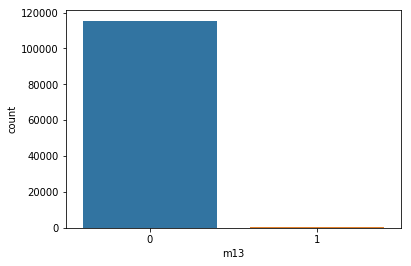

In [10]:
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    print("Percentage: \n",class_values)
    sns.countplot(x = target)
    return None

class_imbalance(y)

In [11]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col


numeric_columns = numeric_features(train_df)
print("Numeric Features: \n {}".format(numeric_columns))
print("===="*20)

# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

categorical_columns = categorical_features(train_df)
print("Categorical Features: \n {}".format(categorical_columns))

Numeric Features: 
 Index(['interest_rate', 'unpaid_principal_bal', 'loan_term', 'loan_to_value',
       'number_of_borrowers', 'debt_to_income_ratio', 'borrower_credit_score',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'],
      dtype='object')
Categorical Features: 
 Index(['source', 'financial_institution', 'origination_date',
       'first_payment_date', 'loan_purpose'],
      dtype='object')


In [12]:
numeric_columns = ['interest_rate', 'unpaid_principal_bal', 'loan_term',
                   'loan_to_value', 'debt_to_income_ratio',
                   'borrower_credit_score','co-borrower_credit_score'
                  ]
categorical_columns = ['source', 'financial_institution', 'origination_date',
                       'first_payment_date','number_of_borrowers','loan_purpose',
                       'insurance_percent', 'insurance_type','m1', 'm2', 'm3',
                       'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12'
                      ]

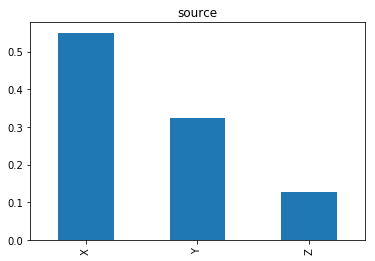

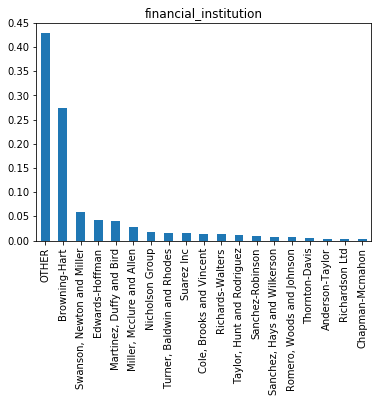

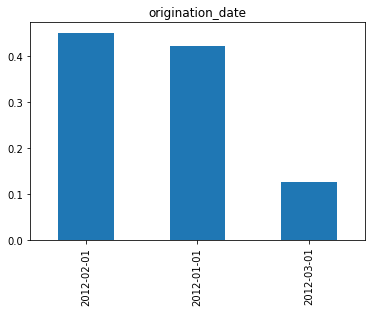

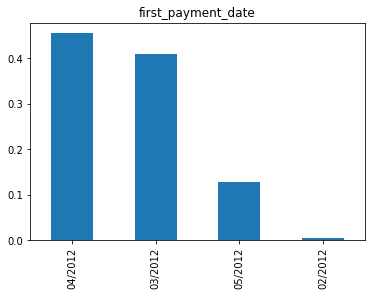

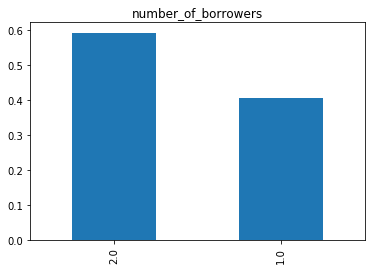

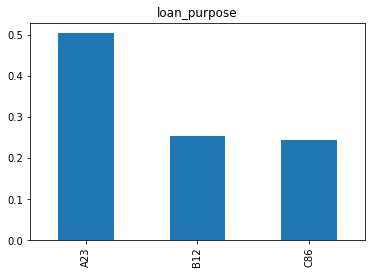

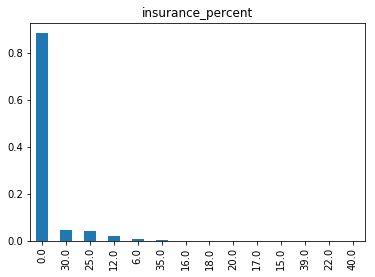

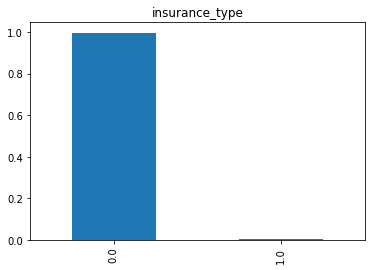

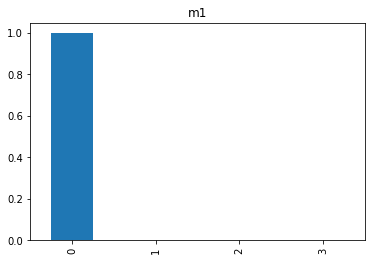

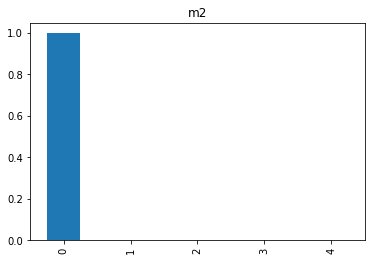

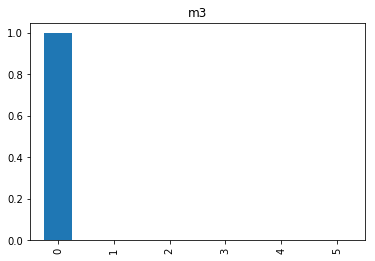

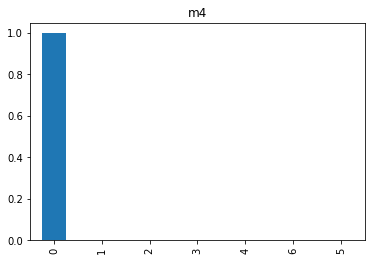

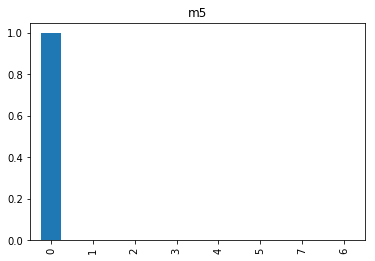

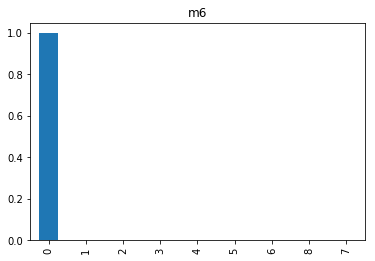

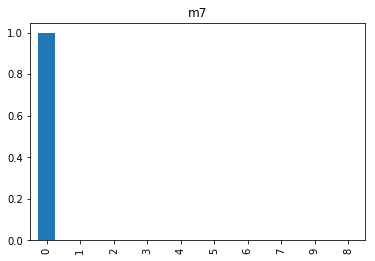

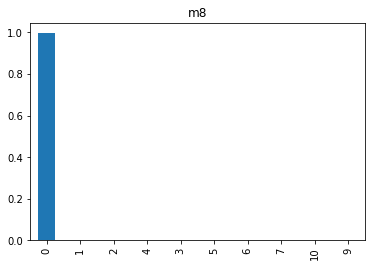

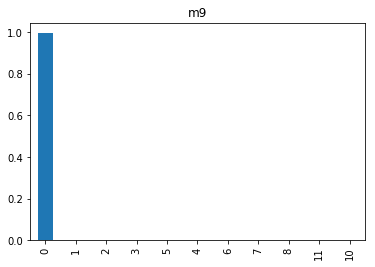

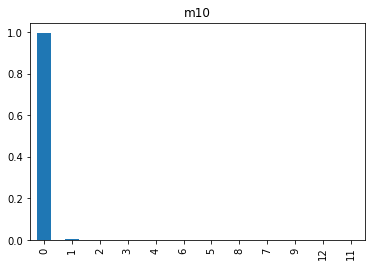

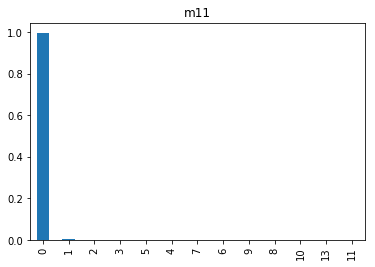

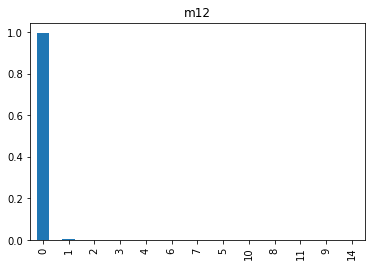

In [13]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe, categorical_columns):
    dataframe = dataframe[categorical_columns]
    for i in dataframe:
        plt.title(i)
        dataframe[i].value_counts(normalize=True).plot(kind='bar')
        plt.show()
        
plot = plot_categorical_columns(train_df, categorical_columns)

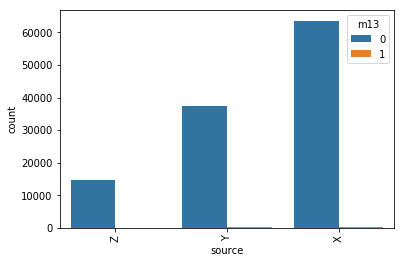

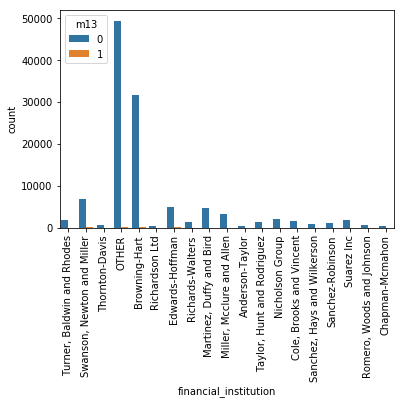

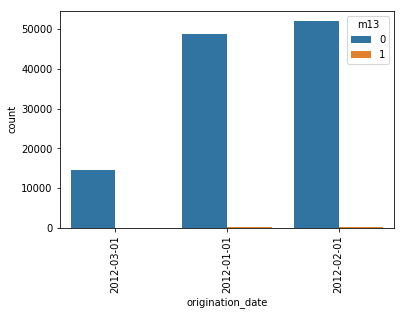

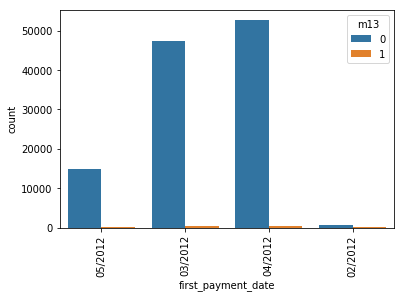

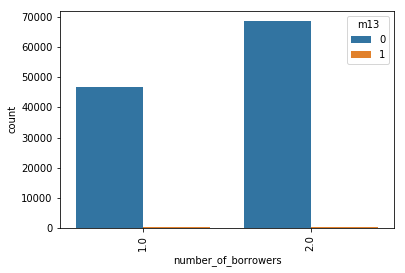

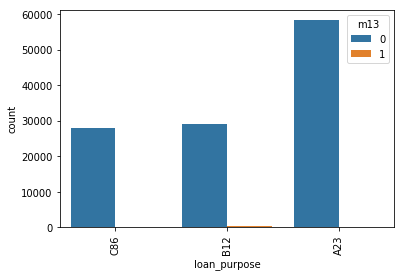

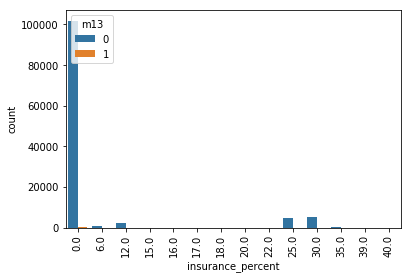

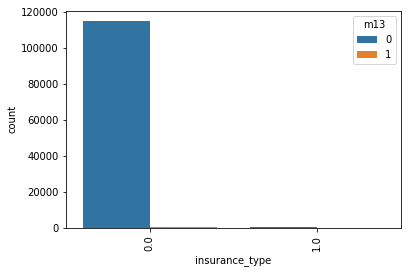

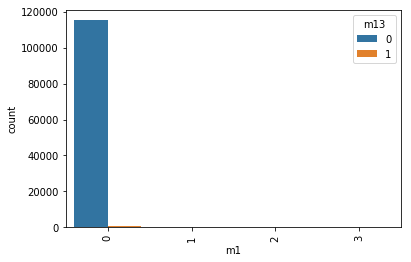

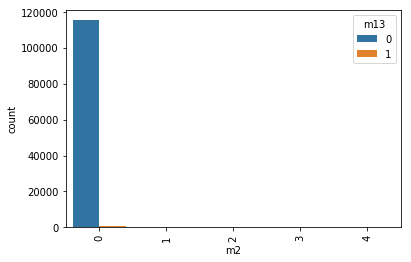

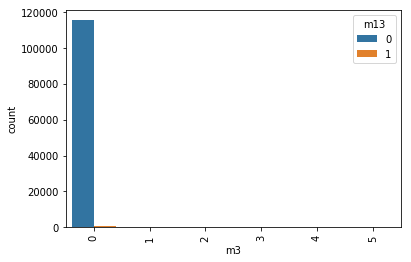

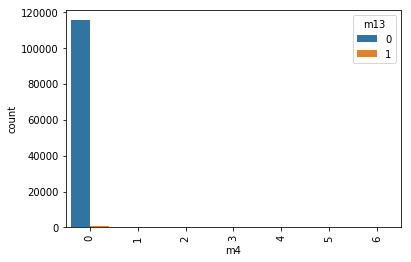

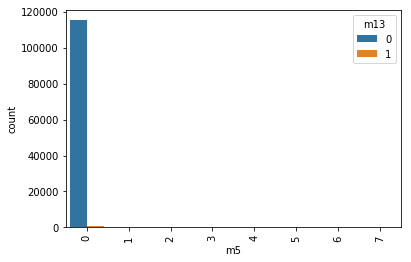

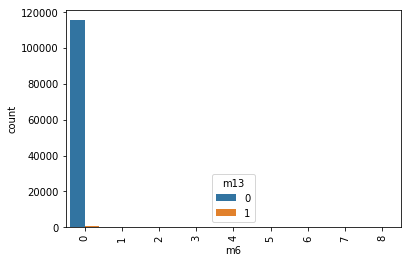

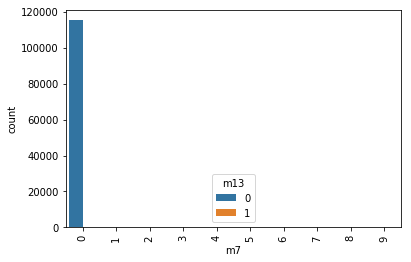

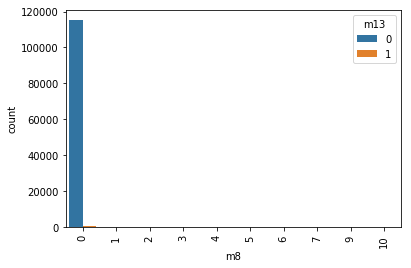

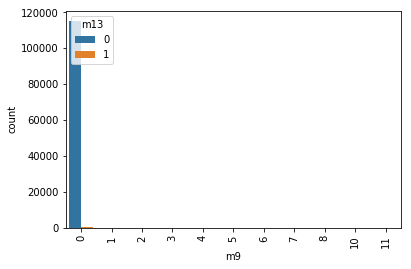

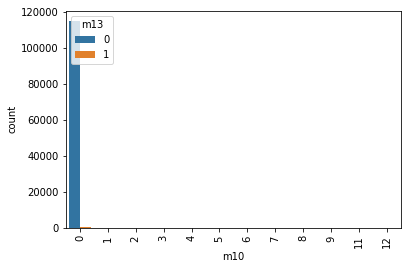

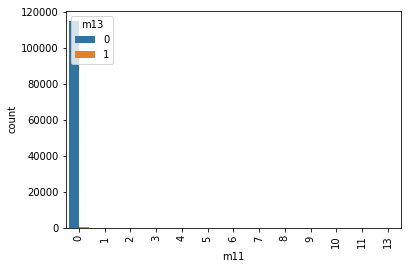

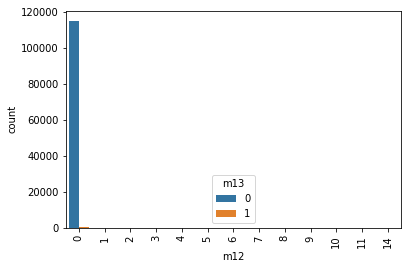

In [14]:
def bivariate_analysis_categorical(dataframe,target, categorical_columns):
    cols = list(dataframe)
    for col in cols:
        if col in categorical_columns:
            sns.countplot(x=dataframe[col],hue=target,data=dataframe)
            plt.xticks(rotation='vertical')
            plt.show()
bivariate_analysis_categorical(train_df,y, categorical_columns)

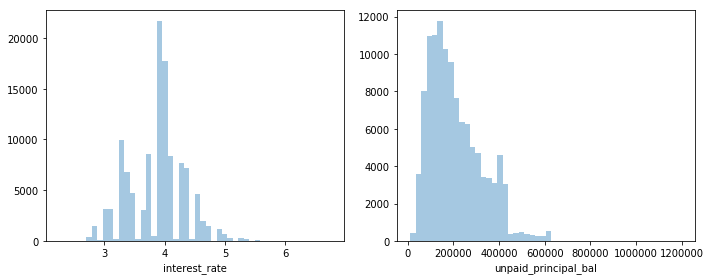

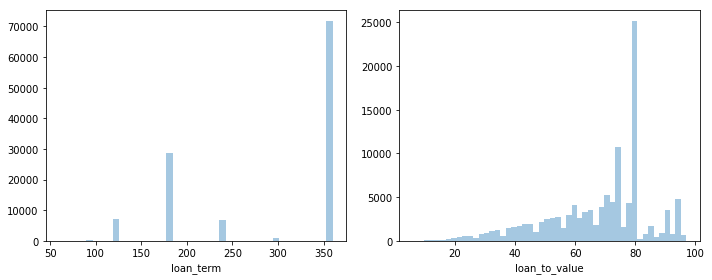

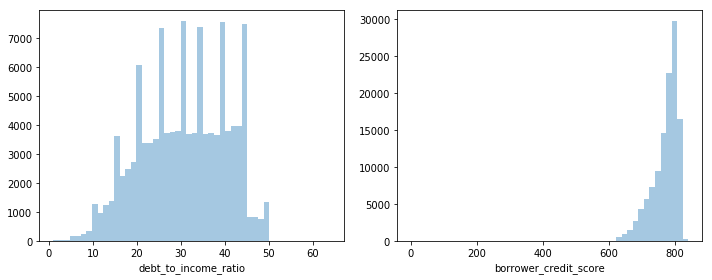

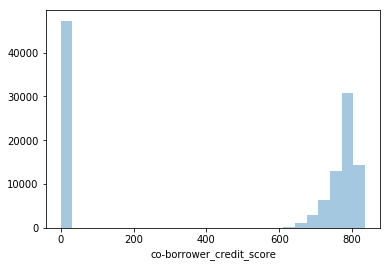

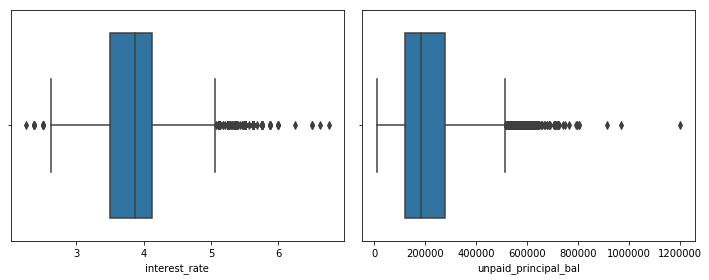

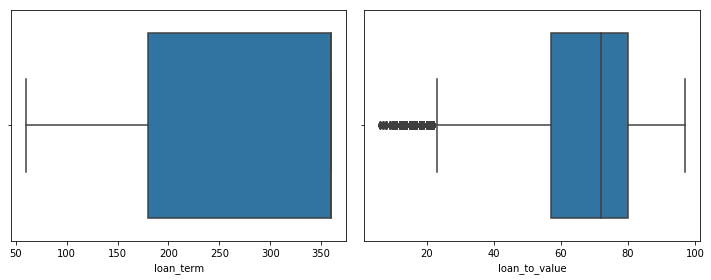

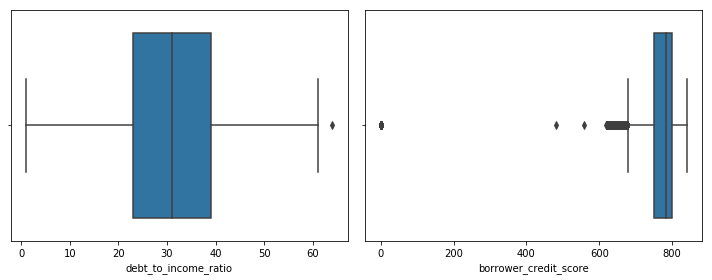

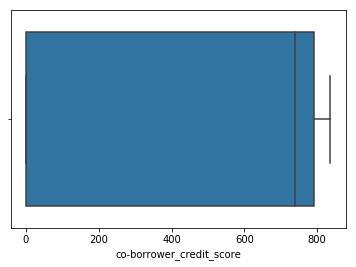

In [15]:
# Function to plot histograms
def plot_continuous_columns(dataframe, numeric_columns):
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)            
            sns.distplot(dataframe[numeric_columns[i+1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)

# Function to plot boxplots
def plot_box_plots(dataframe, numeric_columns):
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])

plot_continuous_columns(train_df, numeric_columns)            
plot_box_plots(train_df, numeric_columns)

In [16]:
# Function to detect outliers in every feature
def detect_outliers(dataframe, numeric_columns):
    cols = list(dataframe)
    
    for column in cols:
        if column in numeric_columns:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)

            print(column + ' ---------', dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0])

detect_outliers(train_df, numeric_columns)


interest_rate --------- 937
unpaid_principal_bal --------- 1742
loan_term --------- 0
loan_to_value --------- 1486
debt_to_income_ratio --------- 1
borrower_credit_score --------- 3729
co-borrower_credit_score --------- 0


In [17]:
def treat_outliers(dataframe, numeric_columns):
    cols = list(dataframe)
    for col in cols:
        if col in numeric_columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


train_df = treat_outliers(train_df, numeric_columns)
print(detect_outliers(train_df, numeric_columns))

interest_rate --------- 0
unpaid_principal_bal --------- 0
loan_term --------- 0
loan_to_value --------- 0
debt_to_income_ratio --------- 0
borrower_credit_score --------- 0
co-borrower_credit_score --------- 0
None


Highly Correlated Variables


loan_term      interest_rate    0.769225
interest_rate  loan_term        0.769225
dtype: float64

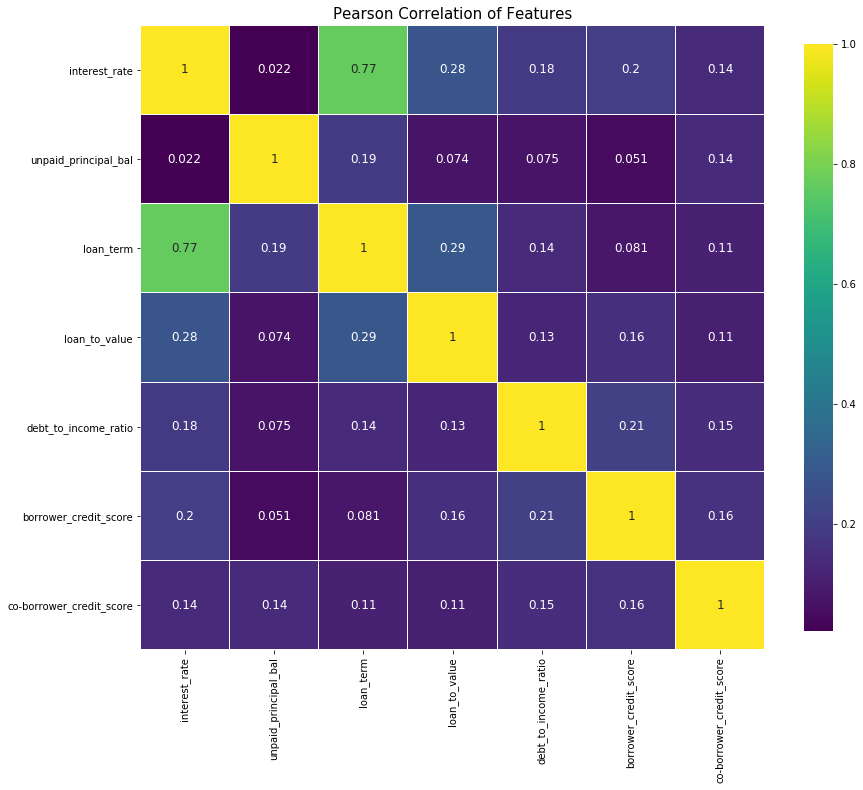

In [18]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr().abs(), 
        cmap = 'viridis',
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    
    correlation = df.corr().unstack().sort_values(kind='quicksort')
    print('Highly Correlated Variables')
    return correlation[((correlation>=0.75) | (correlation<=-0.75)) & (correlation!=1)]

correlation_heatmap(train_df[numeric_columns])

In [19]:
corr_col_to_drop = ['loan_term']
train_df = drop_col(train_df,corr_col_to_drop)
test_df = drop_col(test_df,corr_col_to_drop)

In [20]:
train_df.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,Z,"Turner, Baldwin and Rhodes",4.250,214000,2012-03-01,05/2012,85,1.0,22.0,694.0,...,0,0,0,0,1,0,0,0,0,0
1,Y,"Swanson, Newton and Miller",4.375,144000,2012-01-01,03/2012,72,1.0,43.0,697.0,...,0,0,0,0,0,0,0,0,1,0
2,Z,Thornton-Davis,3.250,366000,2012-01-01,03/2012,49,1.0,33.0,780.0,...,0,0,0,0,0,0,0,0,0,0
3,X,OTHER,4.375,135000,2012-02-01,04/2012,46,2.0,43.0,689.0,...,0,0,0,0,0,0,1,1,1,1
4,X,OTHER,4.375,124000,2012-02-01,04/2012,80,1.0,43.0,689.0,...,2,3,4,5,6,7,8,9,10,11


In [21]:
le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset,columnsToEncode):
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
columns_to_encode = ['origination_date','first_payment_date','financial_institution','loan_purpose','source']
train_df = dummyEncode(train_df, columns_to_encode)
test_df = dummyEncode(test_df, columns_to_encode)
y = pd.DataFrame(le.fit_transform(y))

In [22]:
train_df.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,2,18,4.250,214000,2,3,85,1.0,22.0,694.0,...,0,0,0,0,1,0,0,0,0,0
1,1,15,4.375,144000,0,1,72,1.0,43.0,697.0,...,0,0,0,0,0,0,0,0,1,0
2,2,17,3.250,366000,0,1,49,1.0,33.0,780.0,...,0,0,0,0,0,0,0,0,0,0
3,0,8,4.375,135000,1,2,46,2.0,43.0,689.0,...,0,0,0,0,0,0,1,1,1,1
4,0,8,4.375,124000,1,2,80,1.0,43.0,689.0,...,2,3,4,5,6,7,8,9,10,11


**Baseline Model and Feature Engineering**

**Applying a baseline model**
1. Task - 1: Spliting into training and validation

> **Baseline Regression Model**

There are many Classification algorithms are present in machine learning, which are used for different classification applications. Some of the main classification algorithms are as follows-

1. Logistic Regression
2. DecisionTree Classifier
3. RandomForest Classfier
4. XGBClassifier
5. GradientBoostingClassifier

In [23]:
def run_baseline_model(model, dataframe, target):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    X_train, X_val, y_train, y_val = train_test_split(dataframe, target, test_size=0.3, random_state= 0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    Classification_Report = classification_report(y_val,y_pred) 
    print('\n Model - \n {} \n AUC Score = {} %.2f'.format(str(model),(auc*100)))
    print(" Classification_Report", Classification_Report)
    print('===='*20)
    return None

models = [LogisticRegression,DecisionTreeClassifier, RandomForestClassifier,XGBClassifier,GradientBoostingClassifier]

for model in models:
    # run model
    model = model()
    run_baseline_model(model, train_df, y)
    


 Model - 
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 
 AUC Score = 50.0 %.2f
 Classification_Report               precision    recall  f1-score   support

           0       0.99      1.00      1.00     34633
           1       0.00      0.00      0.00       185

    accuracy                           0.99     34818
   macro avg       0.50      0.50      0.50     34818
weighted avg       0.99      0.99      0.99     34818


 Model - 
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,

In [24]:
class BuildModel():
    
    def __init__(self, ml_model, resample_model=None,
                     featureselection_flag=0, hyperparamatertuning_flag=0):
#         print("Initializing Buildmodel object..")
        self.ml_model = ml_model
        self.resample_model = resample_model
        self.featureselection_flag = featureselection_flag
        self.hyperparamatertuning_flag = hyperparamatertuning_flag
        return None
    
    def resample_data(self, resample_model,dataframe, target):
#         print("resampling data..")
        X_sample, y_sample = resample_model.fit_sample(dataframe, target)  
        return X_sample, y_sample
    
    def feature_selection(self,dataframe, target, number_of_features=None):
#         print("feature selection started...")
        X = dataframe
        y = target
        models = self.ml_model
        if number_of_features == None:
            number_of_features = (self.dataframe.column) * 0.75 
        rfe = RFE(models,number_of_features)
        rfe = rfe.fit(X, y)
        features_series = pd.Series(rfe.ranking_, index=X.columns)
        features = features_series[features_series.values==1].index.tolist() 
        return features
    
    def fit_model(self, dataframe, target):
#         print("fitting model..")
        model = self.ml_model.fit(dataframe, target)
        return model
    
    def validate_model(self, X_valid, y_valid):
#         print("validating model...")
        y_pred = self.predict_label(X_valid)
        y_test = y_valid
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        print("Accuracy:{}\n Precision: {}\n Recall: {}\n f1_score:{}\n roc_auc_score:{}\
               \n classification_report:\n {}".format(accuracy, precision, recall, f1, roc, cr))
        return None
    
    def plot_roc_curve(self, X_valid, y_valid):
        probs = self.predict_label_prob(X_valid)
        fpr, tpr, threshold = roc_curve(y_valid, probs)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    def train_model(self, dataframe, target):
        if self.featureselection_flag:
            self.selected_features = self.feature_selection(dataframe, target, number_of_features = 20)
        X_train, X_valid, y_train, y_valid = train_test_split(dataframe, target, test_size=0.3, random_state=0)
        if self.resample_model != None:
            X_train, y_train = self.resample_data(self.resample_model, X_train, y_train)
        self.final_model = self.fit_model(X_train, y_train)
        self.validate_model(X_valid, y_valid)
        self.plot_roc_curve(X_valid, y_valid)
        return None
    
    def predict_label_prob(self, X_test):
        if self.featureselection_flag:
            X_test = X_test[self.selected_features]
        y_pred = self.final_model.predict_proba(X_test)[:, 1]
        return y_pred 
    
    def predict_label(self, X_test):
        if self.featureselection_flag:
            X_test = X_test[self.selected_features]
        y_pred = self.final_model.predict(X_test)
        return y_pred 

Accuracy:0.8728531219484175
 Precision: 0.028037383177570093
 Recall: 0.6810810810810811
 f1_score:0.053857661893567
 roc_auc_score:0.777479298372666               
 classification_report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93     34633
           1       0.03      0.68      0.05       185

    accuracy                           0.87     34818
   macro avg       0.51      0.78      0.49     34818
weighted avg       0.99      0.87      0.93     34818



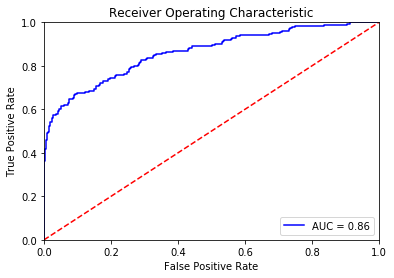

In [25]:
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
estimator=LogisticRegression(C=1.0, intercept_scaling=1,dual=False, 
                             fit_intercept=True, penalty='l2', tol=0.0001)
ml_model = GridSearchCV(estimator=estimator, param_grid=param_grid)
resample_model = SMOTE(kind='regular')

bm_obj_1 = BuildModel(ml_model=ml_model, resample_model=resample_model, featureselection_flag=0)
bm_obj_1.train_model(dataframe = train_df, target=y)

In [28]:
# estimator = XGBClassifier()
# resample_model = SMOTE(kind='regular')
# param_grid = {
#                 'min_child_weight': [1,5],
#                 'gamma': [0.5, 1, 1.5, 2, 5],
#                 'subsample': [0.6, 0.8, 1.0],
#                 'colsample_bytree': [0.6, 0.8, 1.0],
#                 'max_depth': [3, 4]
#              }
# # ml_model = GridSearchCV(estimator=estimator, param_grid=param_grid)
# ml_model = XGBClassifier(max_depth = 2)
# bm_obj_2 = BuildModel(ml_model=ml_model, resample_model=resample_model, featureselection_flag=0)
# bm_obj_2.train_model(dataframe = train_df, target=y)

In [29]:
y_pred = bm_obj_1.predict_label(test_df)

#Create a  DataFrame with the tweet_id and our prediction regarding sentiment
submission = pd.DataFrame({'loan_id':ref_test_df['loan_id'],'m13':y_pred})
print(submission.shape)
submission.to_csv('submission.csv', index=False)
from IPython.display import FileLink
FileLink(r'submission.csv')

(35866, 2)


/kaggle/working/submission.csv